In [2]:
import pandas as pd, numpy as np, matplotlib, os, zipfile
import matplotlib.pyplot as plt, seaborn as sns

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
os.chdir('/home/bdg/kaggle/santander/data')

In [5]:
with zipfile.ZipFile('train.csv.zip') as z:
    with z.open('train.csv') as f:
        sc_train = pd.read_csv(f, header = 0)

In [6]:
with zipfile.ZipFile('test.csv.zip') as z:
    with z.open('test.csv') as f:
        sc_test = pd.read_csv(f, header = 0)

In [7]:
print(sc_train.shape)
print(sc_test.shape)

(4459, 4993)
(49342, 4992)


In [8]:
print(sc_train.info())
print(sc_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4459 entries, 0 to 4458
Columns: 4993 entries, ID to 9fc776466
dtypes: float64(1845), int64(3147), object(1)
memory usage: 169.9+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49342 entries, 0 to 49341
Columns: 4992 entries, ID to 9fc776466
dtypes: float64(4991), object(1)
memory usage: 1.8+ GB
None


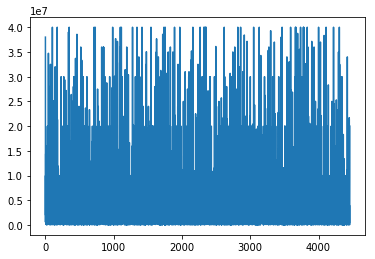

In [9]:
%matplotlib inline
sc_train['target'].plot()
plt.show()

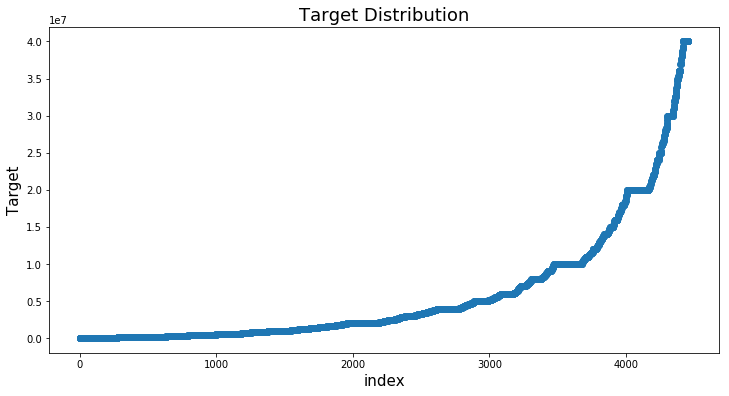

In [10]:
plt.figure(figsize = (12,6))
plt.scatter(range(sc_train.shape[0]), np.sort(sc_train['target'].values))
plt.xlabel('index', fontsize = 15)
plt.ylabel('Target', fontsize = 15)
plt.title('Target Distribution', fontsize = 18)
plt.show()

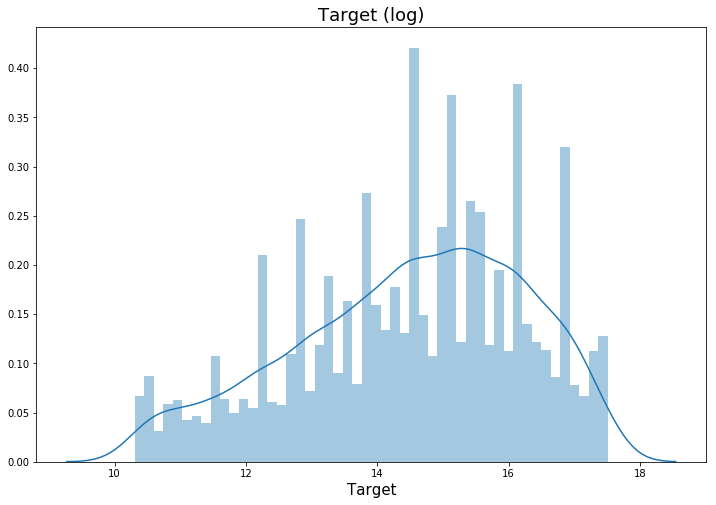

In [11]:
plt.figure(figsize = (12,8))
sns.distplot(np.log1p(sc_train['target'].values), bins = 50)
plt.xlabel('Target', fontsize=15)
plt.title('Target (log)', fontsize = 18)
plt.show()

In [12]:
sc_train.head()

,ID,target,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000d6aaf2,38000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
1,000fbd867,600000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
2,0027d6b71,10000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
3,0028cbf45,2000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
4,002a68644,14400000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0


In [13]:
sc_train['target'].describe()

count    4.459000e+03
mean     5.944923e+06
std      8.234312e+06
min      3.000000e+04
25%      6.000000e+05
50%      2.260000e+06
75%      8.000000e+06
max      4.000000e+07
Name: target, dtype: float64

In [14]:
missing_df = sc_train.isnull().sum(axis = 0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df[missing_df['missing_count'] > 0]
missing_df = missing_df.sort_values(by='missing_count')
missing_df

,column_name,missing_count


In [15]:
dtype_df = sc_train.dtypes.reset_index()
dtype_df.columns = ['Count', 'Column Type']
dtype_df.groupby('Column Type').aggregate('count').reset_index()

,Column Type,Count
0,int64,3147
1,float64,1845
2,object,1


Let's look for columns with constant values:

In [16]:
unique_df = sc_train.nunique().reset_index()
unique_df.columns = ['col_name','unique_count']
constant_df = unique_df[unique_df['unique_count'] == 1]
constant_df.shape

(256, 2)

256 columns with constant values and hence no variance.  These will provide no information to predict the target and will need to be removed.

In [17]:
cols_to_remove = constant_df.col_name.tolist()

In [18]:
cols_to_remove[:3]

['d5308d8bc', 'c330f1a67', 'eeac16933']

In [19]:
sc_test['eeac16933'].describe()

count    4.934200e+04
mean     1.310807e+05
std      1.074090e+07
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.297832e+09
Name: eeac16933, dtype: float64

so at least for this feature, it is constant in training dataset (== 0) and not constant in the test set

In [20]:
unique_df_test = sc_test[cols_to_remove]
unique_df_test_unique = unique_df_test.nunique().reset_index()
unique_df_test_unique.columns = ['col_name','unique_count']
constant_df = unique_df_test_unique[unique_df_test_unique['unique_count'] == 1]
constant_df.shape

(0, 2)

so none of the columns that are constant in the train set are constant in the test set.

In [21]:
X_train = sc_train.drop(['ID', 'target'], axis = 1)
Y_train = np.log1p(sc_train['target'].values)
X_test = sc_test.drop(['ID'], axis = 1)

### Attempt at Principal Component Analysis (PCA)

In [22]:
#first let's remove the target variable
train_data_pca = sc_train.drop(['ID', 'target'], axis = 1)

In [23]:
#standardize the data
from sklearn.preprocessing import StandardScaler
X = train_data_pca.values
X_std = StandardScaler().fit_transform(X)

#Calculate eigenvectors and eigenvalues of covariance matrix
mean_vec = np.mean(X_std, axis = 0)
cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

#Create list of (eigenvalue, eigenvector) tuples and sort high to low
eig_pairs = [ (np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
eig_pairs.sort(key = lambda x: x[0], reverse= True)

#Calculation of Explained Variance and cumulative explained variance from eigenvalues
tot = sum(eig_vals)
var_exp = np.asarray([(i/tot)*100 for i in sorted(eig_vals, reverse=True)])
cum_var_exp = np.cumsum(var_exp)
var_exp = var_exp.real
cum_var_exp = cum_var_exp.real


In [24]:
print(cum_var_exp[[50, 100, 200, 500]])
index = np.where(cum_var_exp > 75)
index[0][0]

[21.69853704 30.20533735 42.11583176 65.2505278 ]


697

So, we can see that, approximately, 50 components can explain 21% of variance, and it takes about 500 components to account for 65% of variance.  We do not get to 75% until 697 components

#### some graphing

In [25]:
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import matplotlib.image as mpimg

In [26]:
trace1 = go.Scatter(
    x=list(range(train_data_pca.shape[1])),
    y= cum_var_exp,
    mode='lines+markers',
    name="'Cumulative Explained Variance'",
    hoverinfo= cum_var_exp,
    line=dict(
        shape='spline',
        color='goldenrod'
        )
)
trace2 = go.Scatter(
    x = list(range(train_data_pca.shape[1])),
    y = var_exp,
    mode='lines+markers',
    name="'Individual Explained Variance'",
    hoverinfo= var_exp,
    line=dict(
        shape='linear',
        color='black'
        )
)
fig = tls.make_subplots(insets=[{'cell':(1,1), 'l': 0.7, 'b':0.5}],
                           print_grid=True)

fig.append_trace(trace1,1,1)
fig.append_trace(trace2,1,1)
fig.layout.title = 'Explained Variance Plots - Full and Zoomed-in'
fig.layout.xaxis = dict(range=[0,700], title='Feature Columns')
fig.layout.yaxis= dict(range=[0,80], title='Explained Variance')
fig['data'] += [go.Scatter(x=list(range(train_data_pca.shape[1])), 
                            y=cum_var_exp, xaxis='x2', yaxis='y2',
                              name='Cumulative Explained Variance')]

py.iplot(fig, filename= 'inset example')

This is the format of your plot grid:
[ (1,1) x1,y1 ]

With insets:
[ x2,y2 ] over [ (1,1) x1,y1 ]



<div>
    <a href="https://plot.ly/~gilbert.brian/1/?share_key=Ip1BKCq2Sky8ElFxwrC38K" target="_blank" title="Plot 1" style="display: block; text-align: center;"><img src="https://plot.ly/~gilbert.brian/1.png?share_key=Ip1BKCq2Sky8ElFxwrC38K" alt="Plot 1" style="max-width: 100%;width: 600px;"  width="600" onerror="this.onerror=null;this.src='https://plot.ly/404.png';" /></a>
    <script data-plotly="gilbert.brian:1" sharekey-plotly="Ip1BKCq2Sky8ElFxwrC38K" src="https://plot.ly/embed.js" async></script>
</div>


From the graph it appears somewhere between 1000 and 1500 would be a good spot to limit the components.  Another method retains only those components associated with eigenvalues greater than 1:

In [27]:
np.where(eig_vals < 1)[0][0]

1152

In [28]:
print(cum_var_exp[1152])
print(cum_var_exp[1152]-cum_var_exp[1151])
print(cum_var_exp[1000])
print(cum_var_exp[1000]-cum_var_exp[999])

88.8181876625258
0.02157349197767644
85.215946874416
0.02644085901465587


From the above, it seems reasonable to retain the first 1000 components

In [29]:
from sklearn.decomposition import PCA 

In [30]:
pca = PCA(n_components = 1000)
X1000 = pca.fit_transform(X_std)

In [31]:
np.sum(pca.explained_variance_ratio_)

0.8485121637805823

In [32]:
len(pca.components_[:,0])

1000

In [33]:
scaler = StandardScaler().fit(X)
X_train_scaled = pd.DataFrame(scaler.transform(X))
X_test_scaled = pd.DataFrame(scaler.transform(X_test.values))

In [34]:
X_train_scaled.head()

,0,1,2,3,4,5,6,7,8,9,...,4981,4982,4983,4984,4985,4986,4987,4988,4989,4990
0,-0.037646,-0.021639,-0.04689,-0.019205,-0.017437,-0.053221,-0.022451,-0.024846,-0.267393,-0.097765,...,-0.114959,-0.100403,-0.178522,-0.114247,-0.014977,-0.025715,-0.022134,-0.072342,-0.056363,-0.125852
1,-0.037646,-0.021639,-0.04689,-0.019205,-0.017437,-0.053221,-0.022451,-0.024846,-0.038443,-0.097765,...,-0.114959,-0.100403,-0.178522,-0.114247,-0.014977,-0.025715,-0.022134,-0.072342,-0.056363,-0.125852
2,-0.037646,-0.021639,-0.04689,-0.019205,-0.017437,-0.053221,-0.022451,-0.024846,-0.267393,-0.097765,...,-0.114959,-0.100403,-0.178522,-0.114247,-0.014977,-0.025715,-0.022134,-0.072342,-0.056363,-0.125852
3,-0.037646,-0.021639,-0.04689,-0.019205,-0.017437,-0.053221,-0.022451,-0.024846,-0.267393,-0.097765,...,-0.114959,-0.100403,-0.178522,-0.114247,-0.014977,-0.025715,-0.022134,-0.072342,-0.056363,-0.125852
4,-0.037646,-0.021639,-0.04689,-0.019205,-0.017437,-0.053221,-0.022451,-0.024846,-0.059257,-0.097765,...,-0.114959,-0.100403,-0.178522,-0.114247,-0.014977,-0.025715,-0.022134,-0.072342,-0.056363,-0.125852


In [35]:
X_test_scaled.head()

,0,1,2,3,4,5,6,7,8,9,...,4981,4982,4983,4984,4985,4986,4987,4988,4989,4990
0,-0.037646,-0.021639,-0.04689,-0.019205,-0.017437,-0.053221,-0.022451,-0.024846,-0.267393,-0.097765,...,-0.114959,-0.100403,-0.178522,-0.114247,-0.014977,-0.025715,-0.022134,-0.072342,-0.056363,-0.125852
1,-0.037646,-0.021639,-0.04689,-0.019205,-0.017437,-0.053221,-0.022451,-0.024846,-0.267393,-0.097765,...,-0.114959,-0.100403,-0.178522,-0.114247,-0.014977,-0.025715,-0.022134,-0.072342,-0.056363,-0.125852
2,-0.037646,-0.021639,-0.04689,-0.019205,-0.017437,-0.053221,-0.022451,-0.024846,-0.267393,-0.097765,...,-0.114959,-0.100403,-0.178522,-0.114247,-0.014977,-0.025715,-0.022134,-0.072342,-0.056363,-0.125852
3,-0.037646,-0.021639,-0.04689,-0.019205,-0.017437,-0.053221,-0.022451,-0.024846,-0.267393,-0.097765,...,-0.114959,-0.100403,-0.178522,-0.114247,-0.014977,-0.025715,-0.022134,-0.072342,-0.056363,-0.125852
4,-0.037646,-0.021639,-0.04689,-0.019205,-0.017437,-0.053221,-0.022451,-0.024846,-0.267393,-0.097765,...,-0.114959,-0.100403,-0.178522,-0.114247,-0.014977,-0.025715,-0.022134,-0.072342,-0.056363,-0.125852


In [36]:
pca = PCA(n_components = 1000)
X1000 = pd.DataFrame(pca.fit_transform(X_train_scaled))

In [37]:
from sklearn.ensemble import RandomForestRegressor

In [38]:
rf = RandomForestRegressor()
rf.fit(X_train_scaled, Y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [47]:
results = rf.predict(X_test_scaled)
results = np.exp(results)

In [48]:
submission = pd.DataFrame()
submission['ID'] = sc_test['ID']
submission['target'] = results
submission.to_csv('submision.csv', index=False)

In [43]:
avg = np.mean(sc_train['target'])
submission2 = pd.DataFrame()
submission2['ID'] = sc_test['ID']
submission2['target'] = avg
submission2.to_csv('submision2.csv', index=False)